In [1]:
import os
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from laplace import Laplace
import pandas as pd


from torch.optim.swa_utils import AveragedModel, SWALR


from CIFAR_Data import get_cifar10_loaders
from CIFAR_MODEL import FixupWideResNet


import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from torchvision import transforms, datasets

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        #
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [3]:
datapath = os.path.join(os.getcwd(),"CIFAR-10-C","CIFAR-10-C")
corruptions = os.listdir(datapath)
corruptions.remove('desktop.ini')

In [4]:
## Load corrupted images on memory
corrupted_images = {}

for corruption in corruptions:
  if 'labels' in corruption:
    labels = np.load(os.path.join(datapath,corruption))
    continue

  corruption_type = corruption.split('.')[0]

  imgs = np.load(os.path.join(datapath,corruption))
  corrupted_images[corruption_type] = imgs

In [5]:
# corrupted_images_severity = {}
# corrupted_images_labels = {}


# for severity in range(0,5):

#     ax = np.concatenate([corrupted_images[corruption][severity*10000:(severity+1)*10000] for corruption in corrupted_images.keys()],axis=0)

#     corrupted_images_severity[str(severity+1)] = ax

#     ax = np.concatenate([labels[severity*10000:(severity+1)*10000] for _ in range(0,19)],axis=0)

#     corrupted_images_labels[str(severity+1)] = ax

In [6]:
cor = "motion_blur"
#cor = ['snow', 'gaussian_noise', 'motion_blur']

np_x = corrupted_images[cor]

In [7]:
corrupted_images_severity = {}
corrupted_images_labels = {}


for severity in range(0,5):

    ax = np_x[severity*10000:(severity+1)*10000]

    corrupted_images_severity[str(severity+1)] = ax

    ax = labels[severity*10000:(severity+1)*10000]

    corrupted_images_labels[str(severity+1)] = ax

In [8]:
class DatafeedImage(torch.utils.data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        #img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

In [9]:
def load_corrupted_cifar10(severity,data,labels, batch_size=256,workers=1):
    """ load corrupted CIFAR10 dataset """

    # x_file = data_dir + '/CIFAR-10-C/CIFAR10_c%d.npy' % severity
    # np_x = np.load(x_file)
    # y_file = data_dir + '/CIFAR-10-C/CIFAR10_c_labels.npy'
    # np_y = np.load(y_file).astype(np.int64)

    np_y = labels[severity].astype(np.int64)
    np_x = data[severity]

    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    
    dataset = DatafeedImage(np_x, np_y, transform)
    #dataset = data_utils.Subset(dataset, torch.randint(len(dataset), (10000,)))

    loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size)

    return loader

In [10]:
def get_brier_score(probs, targets):
    targets = F.one_hot(targets, num_classes=probs.shape[1])
    return torch.mean(torch.sum((probs - targets)**2, axis=1)).item()

In [11]:
def get_calib(pys, y_true, M=100):
    pys, y_true = pys.cpu().numpy(), y_true.cpu().numpy()
    # Put the confidence into M bins
    _, bins = np.histogram(pys, M, range=(0, 1))

    labels = pys.argmax(1)
    confs = np.max(pys, axis=1)
    conf_idxs = np.digitize(confs, bins)

    # Accuracy and avg. confidence per bin
    accs_bin = []
    confs_bin = []
    nitems_bin = []

    for i in range(M):
        labels_i = labels[conf_idxs == i]
        y_true_i = y_true[conf_idxs == i]
        confs_i = confs[conf_idxs == i]

        acc = np.nan_to_num(np.mean(labels_i == y_true_i), 0)
        conf = np.nan_to_num(np.mean(confs_i), 0)

        accs_bin.append(acc)
        confs_bin.append(conf)
        nitems_bin.append(len(labels_i))

    accs_bin, confs_bin = np.array(accs_bin), np.array(confs_bin)
    nitems_bin = np.array(nitems_bin)

    ECE = np.average(np.abs(confs_bin-accs_bin), weights=nitems_bin/nitems_bin.sum())
    MCE = np.max(np.abs(accs_bin - confs_bin))

    return ECE, MCE

In [12]:
@torch.no_grad()
def mixture_model_pred(components, x, mixture_weights,MAP=False):

    out = 0.  # out will be a tensor

    for model, pi in zip(components, mixture_weights):
        if MAP:
            out_prob = torch.softmax(model(X),dim=1)
        else:    
            out_prob = model(x)
        
        out += pi * out_prob
        
    return out

In [13]:
n_models = 3
ECE_ = {"Diag":{},"Kron":{},"MAP":{},"SWA":{}}
NLL_ = {"Diag":{},"Kron":{},"MAP":{},"SWA":{}}
BRI_ = {"Diag":{},"Kron":{},"MAP":{},"SWA":{}}

loss_fn = torch.nn.CrossEntropyLoss()

pi = torch.ones(n_models, device=device) / n_models

In [14]:
### SWAG

learning_rate = 1e-6
epochs = 15
n_models = 3

In [15]:
file_models = [os.path.join(os.getcwd(),"CIFAR_m"+str(n+1)+".pth") for n in range(n_models)]

models = [FixupWideResNet(16, 4, 10, dropRate=0.3).to(device) for _ in range(n_models)]

for file, model in zip(file_models,models):
    model.load_state_dict(torch.load(file))
    model.eval()

SWAG_models = []

train_dataloader, test_dataloader = get_cifar10_loaders()

loss_fn = torch.nn.CrossEntropyLoss()

for n,model in enumerate(models):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    swa_model = AveragedModel(model)
    #scheduler = CosineAnnealingLR(optimizer, T_max=100)
    #swa_start = int((epochs)*(.75))
    swa_start = 0
    swa_scheduler = SWALR(optimizer, swa_lr=0.8e-6)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)

        if epochs > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()

        test_loop(test_dataloader, model, loss_fn)

    print(f"Training routine finished for model: {n+1}")


    torch.optim.swa_utils.update_bn(train_dataloader, swa_model)

    SWAG_models.append(swa_model)

Epoch 1
-------------------------------
loss: 0.078604  [    0/50000]
loss: 0.062250  [12800/50000]
loss: 0.056970  [25600/50000]
loss: 0.067382  [38400/50000]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.374938 

Epoch 2
-------------------------------
loss: 0.048245  [    0/50000]
loss: 0.066860  [12800/50000]
loss: 0.072052  [25600/50000]
loss: 0.086952  [38400/50000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.366722 

Epoch 3
-------------------------------
loss: 0.068799  [    0/50000]
loss: 0.035995  [12800/50000]
loss: 0.102158  [25600/50000]
loss: 0.062693  [38400/50000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.365169 

Epoch 4
-------------------------------
loss: 0.073163  [    0/50000]
loss: 0.035190  [12800/50000]
loss: 0.070071  [25600/50000]
loss: 0.058118  [38400/50000]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.377050 

Epoch 5
-------------------------------
loss: 0.046815  [    0/50000]
loss: 0.034210  [12800/50000]
loss: 0.023025  [25600/50000]
loss: 0.097054  [38400

In [16]:
file_models = [os.path.join(os.getcwd(),"CIFAR_m"+str(n+1)+".pth") for n in range(n_models)]

models = [FixupWideResNet(16, 4, 10, dropRate=0.3).to(device) for _ in range(n_models)]

train_dataloader, test_dataloader = get_cifar10_loaders()

for file, model in zip(file_models,models):
    model.load_state_dict(torch.load(file))
    model.eval()

LLA_D = []
LLA_K = []

for model in models:
### Laplace Approximation Diagonal
    la = Laplace(model, 'classification',
                subset_of_weights='last_layer',
                hessian_structure='diag')
        
    la.fit(train_dataloader)
    la.optimize_prior_precision(method='marglik',
                pred_type = "glm",
                link_approx = "probit",
                n_samples = 100)
    LLA_D.append(la)

### Laplace Approximation Kronocker Factor...
    la = Laplace(model, 'classification',
                subset_of_weights='last_layer',
                hessian_structure='kron')
        
    la.fit(train_dataloader)
    la.optimize_prior_precision(method='marglik',
                pred_type = "glm",
                link_approx = "probit",
                n_samples = 100)
    LLA_K.append(la)

In [17]:
for sv in range(0,6):

    if sv == 0:
        test_dataloader
    else:
        test_dataloader = load_corrupted_cifar10(str(sv),corrupted_images_severity,corrupted_images_labels)

    all_y_true = list()
    all_y_prob_D = list()
    all_y_prob_K = list()
    all_y_prob_MAP = list()
    all_y_prob_SWA = list()


    for (X,y) in test_dataloader:

        X , y = X.to(device), y.to(device)
        
        y_pred_MAP = mixture_model_pred(models, X, pi,True)

        y_pred_D = mixture_model_pred(LLA_D, X, pi)
        y_pred_K = mixture_model_pred(LLA_K, X, pi)
        y_pred_SWA = mixture_model_pred(SWAG_models, X, pi,True)

        all_y_true.append(y.cpu())

        all_y_prob_MAP.append(y_pred_MAP.cpu().detach())
        all_y_prob_D.append(y_pred_D.cpu())
        all_y_prob_K.append(y_pred_K.cpu())
        all_y_prob_SWA.append(y_pred_SWA.cpu().detach())


    all_y_prob_MAP = torch.cat(all_y_prob_MAP, dim=0)
    all_y_prob_SWA = torch.cat(all_y_prob_SWA, dim=0)


    all_y_prob_D = torch.cat(all_y_prob_D, dim=0)
    all_y_prob_K = torch.cat(all_y_prob_K, dim=0)

    all_y_true = torch.cat(all_y_true, dim=0)

    ECE_["Diag"][str(sv)] = get_calib(all_y_prob_D,all_y_true)
    ECE_["Kron"][str(sv)] = get_calib(all_y_prob_K,all_y_true)
    ECE_["MAP"][str(sv)] = get_calib(all_y_prob_MAP,all_y_true)
    ECE_["SWA"][str(sv)] = get_calib(all_y_prob_SWA,all_y_true)

    BRI_["Diag"][str(sv)] = get_brier_score(all_y_prob_D,all_y_true)
    BRI_["Kron"][str(sv)] = get_brier_score(all_y_prob_K,all_y_true)
    BRI_["MAP"][str(sv)] = get_brier_score(all_y_prob_MAP,all_y_true)
    BRI_["SWA"][str(sv)] = get_brier_score(all_y_prob_SWA,all_y_true)

    NLL_["Diag"][str(sv)] = loss_fn(all_y_prob_D.log(), all_y_true).item()
    NLL_["Kron"][str(sv)] = loss_fn(all_y_prob_K.log(), all_y_true).item()
    NLL_["MAP"][str(sv)] = loss_fn(all_y_prob_MAP.log(), all_y_true).item()
    NLL_["SWA"][str(sv)] = loss_fn(all_y_prob_SWA.log(), all_y_true).item()

d:\Users\chris\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Users\chris\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Users\chris\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
ECE_D = pd.DataFrame.from_dict(ECE_["Diag"]).T
ECE_K = pd.DataFrame.from_dict(ECE_["Kron"]).T
ECE_MAP = pd.DataFrame.from_dict(ECE_["MAP"]).T
ECE_SWA = pd.DataFrame.from_dict(ECE_["SWA"]).T


BRI_D = pd.DataFrame.from_dict(BRI_["Diag"],orient='index')
BRI_K = pd.DataFrame.from_dict(BRI_["Kron"],orient='index')
BRI_MAP = pd.DataFrame.from_dict(BRI_["MAP"],orient='index')
BRI_SWA = pd.DataFrame.from_dict(BRI_["SWA"],orient='index')


NLL_D = pd.DataFrame.from_dict(NLL_["Diag"],orient='index')
NLL_K = pd.DataFrame.from_dict(NLL_["Kron"],orient='index')
NLL_MAP = pd.DataFrame.from_dict(NLL_["MAP"],orient='index')
NLL_SWA = pd.DataFrame.from_dict(NLL_["SWA"],orient='index')

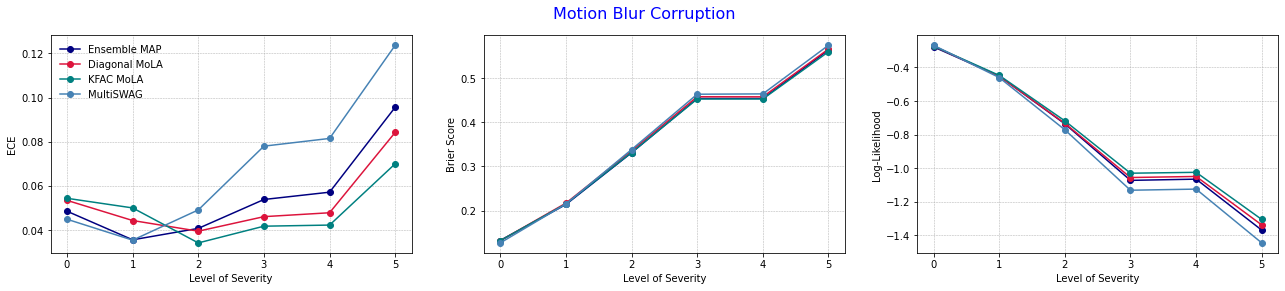

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(22, 4))

fig.suptitle('Motion Blur Corruption', fontsize=16,color="b")

axs[0].plot(ECE_MAP[0],'-o',label = "Ensemble MAP", color = "navy")
axs[0].plot(ECE_D[0],'-o',label = "Diagonal MoLA", color = "crimson")
axs[0].plot(ECE_K[0],'-o',label = "KFAC MoLA", color = "teal")
axs[0].plot(ECE_SWA[0],'-o',label = "MultiSWAG", color = "steelblue")


axs[0].set_xlabel(r"Level of Severity")
axs[0].set_ylabel(r"ECE")

axs[0].legend(frameon=False)
axs[0].grid(True,linestyle = '--', linewidth = 0.5)


axs[1].plot(BRI_MAP,'-o',label = "Ensemble MAP", color = "navy")
axs[1].plot(BRI_D,'-o',label = "Diagonal MoLA", color = "crimson")
axs[1].plot(BRI_K,'-o',label = "KFAC MoLA", color = "teal")
axs[1].plot(BRI_SWA,'-o',label = "MultiSWAG", color = "steelblue")

axs[1].set_xlabel(r"Level of Severity")
axs[1].set_ylabel(r"Brier Score")

#axs[1].legend(frameon=False)
axs[1].grid(True,linestyle = '--', linewidth = 0.5)



axs[2].plot(-NLL_MAP,'-o',label = "Ensemble MAP", color = "navy")
axs[2].plot(-NLL_D,'-o',label = "Diagonal MoLA", color = "crimson")
axs[2].plot(-NLL_K,'-o',label = "KFAC MoLA", color = "teal")
axs[2].plot(-NLL_SWA,'-o',label = "MultiSWAG", color = "steelblue")

axs[2].set_xlabel(r"Level of Severity")
axs[2].set_ylabel(r"Log-Likelihood")

#axs[1].legend(frameon=False)
axs[2].grid(True,linestyle = '--', linewidth = 0.5)